# Detection of Rice Varieties

## Problem Statement
- Classify rice varieties using ANN, DNN and CNN models.


## Description:

> **Dataset :** https://www.muratkoklu.com/datasets/

- Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. 

- With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. 

- In this study, `Arborio`, `Basmati`, `Ipsala`, `Jasmine` and `Karacadag`, which are five different varieties of rice often grown in Turkey, are used. 

- A total of 75,000 grain images, 15,000 from each of these varieties, are included in the dataset. 


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
# importing Open CV library
import cv2
import random
import os
from os import listdir
from PIL import Image

import tensorflow as  tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Lambda
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model  
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras import optimizers, losses
import seaborn as sns
from keras.models import Sequential
from glob import glob
from skimage import io
from tensorflow import io


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Visualising the Dataset

### Number of Classes

In [3]:
# glob function is useful for getting number of classes
dataset_folder = glob(r"C:\Users\vilas\Rice_Image_Dataset\*")
print("Number of Classes are:", len(dataset_folder))

Number of Classes are: 5


### Path of all the classes' folders

In [4]:
dataset_folder

['C:\\Users\\vilas\\Rice_Image_Dataset\\Arborio',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Basmati',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Ipsala',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Jasmine',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Karacadag']

### Finding out Number of Images in each Class

In [5]:
number_classes = {'Arborio': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Arborio')),
'Basmati': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Basmati')),
'Ipsala': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Ipsala')),
'Jasmine': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Jasmine')),
'Karacadag': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Karacadag'))}

number_classes_df= pd.DataFrame(data= number_classes.values(), index=number_classes.keys(), columns=['Number of Images'])
number_classes_df

,Number of Images
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


### Plotting Image Size

In [6]:
directories = {'Arborio': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Arborio\\',
'Basmati': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Basmati\\',
'Ipsala': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Ipsala\\',
'Jasmine': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Jasmine\\',
'Karacadag': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Karacadag\\'}

def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape

    return h,w

In [7]:
import dask.bag as db
import dask
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 2.22 ss
[########################################] | 100% Completed | 2.13 ss
[########################################] | 100% Completed | 2.24 ss
[########################################] | 100% Completed | 2.36 ss
[########################################] | 100% Completed | 2.34 ss


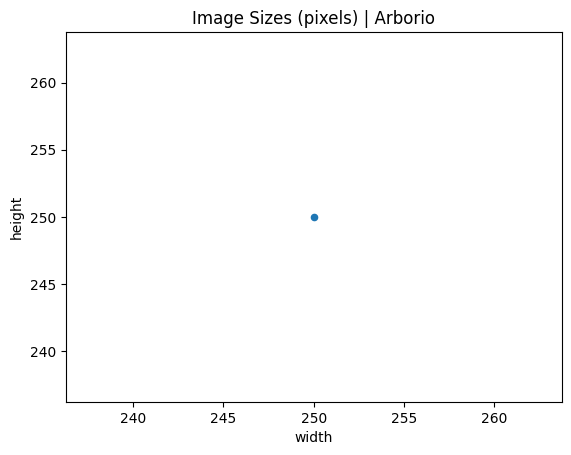

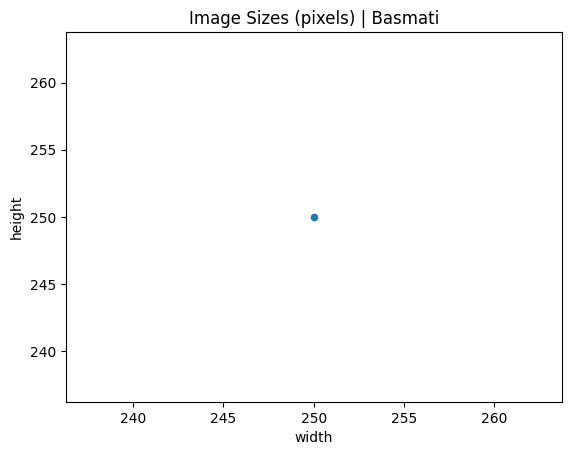

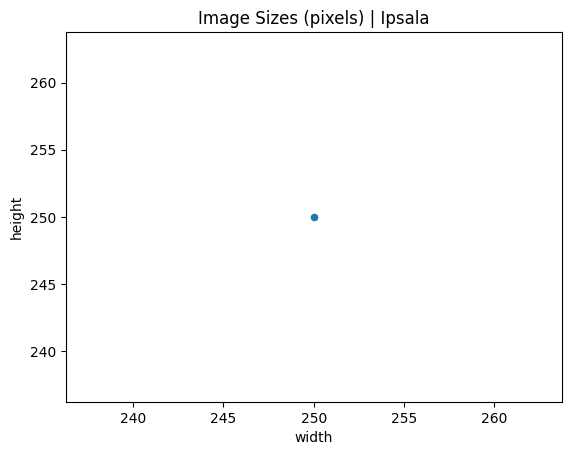

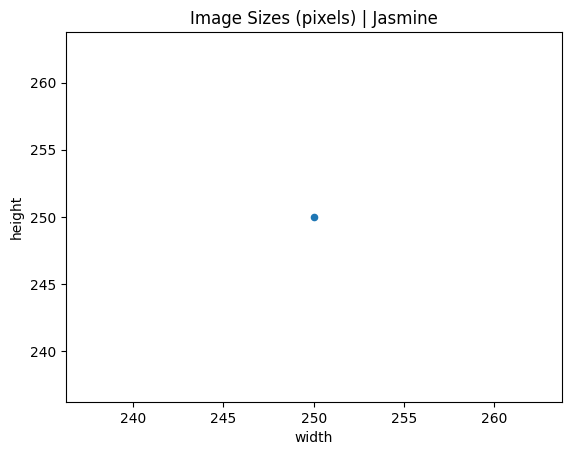

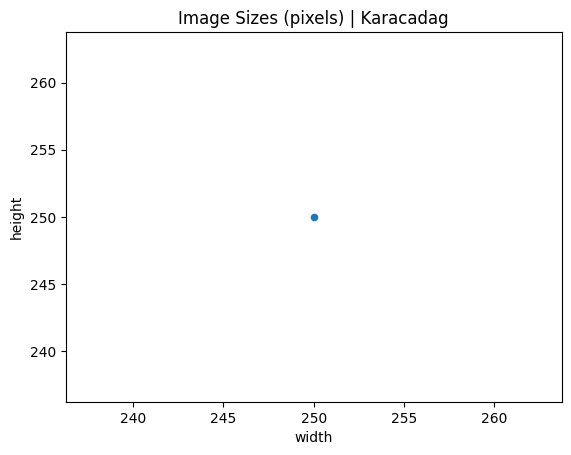

In [8]:
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = db.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Displaying 20 random Grain images of the dataset with their labels

In [10]:
data = r"C:\Users\vilas\Rice_Image_Dataset"

In [11]:
image_dir = Path(data)

# Get filepaths and labels
filepaths =  list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [12]:
image_df

,Filepath,Label
0,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
1,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
2,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
3,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
4,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
...,...,...
74995,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag
74996,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag
74997,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag
74998,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag


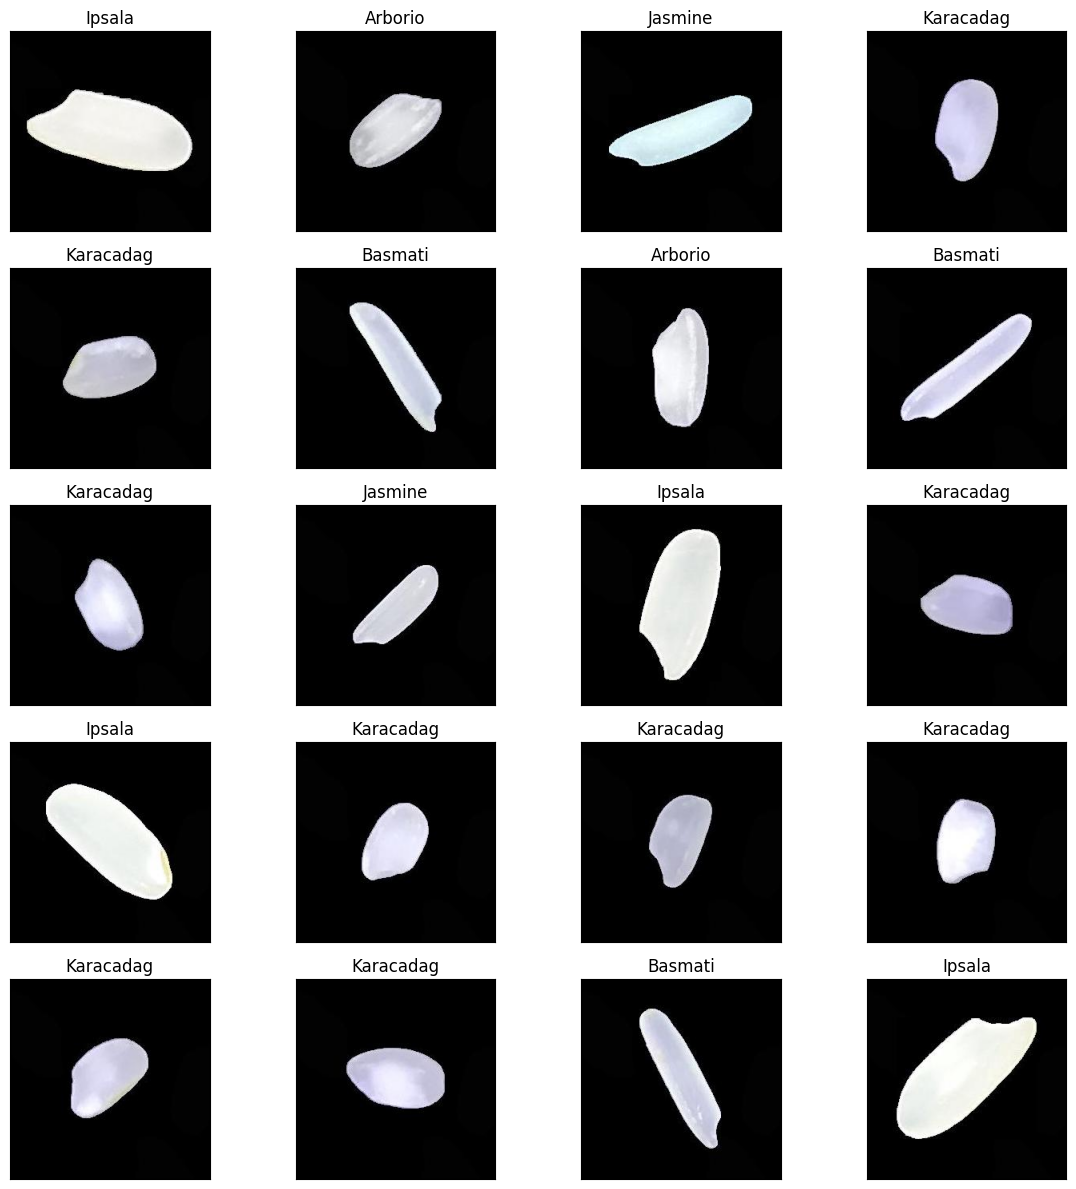

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Displaying Grain Images seperately

### 1. Basmati Rice

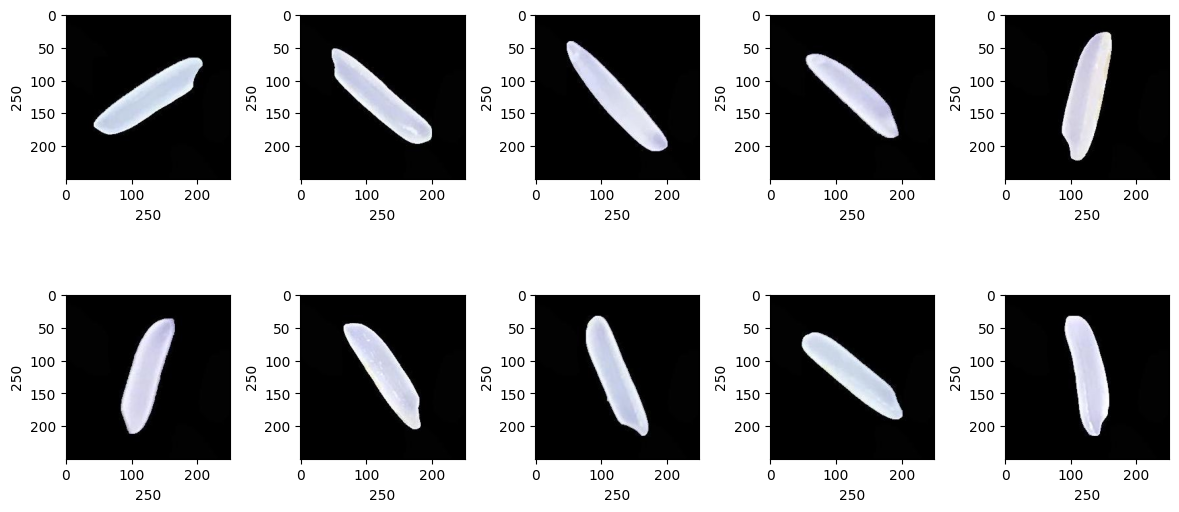

In [14]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Basmati"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 2. Arborio Rice

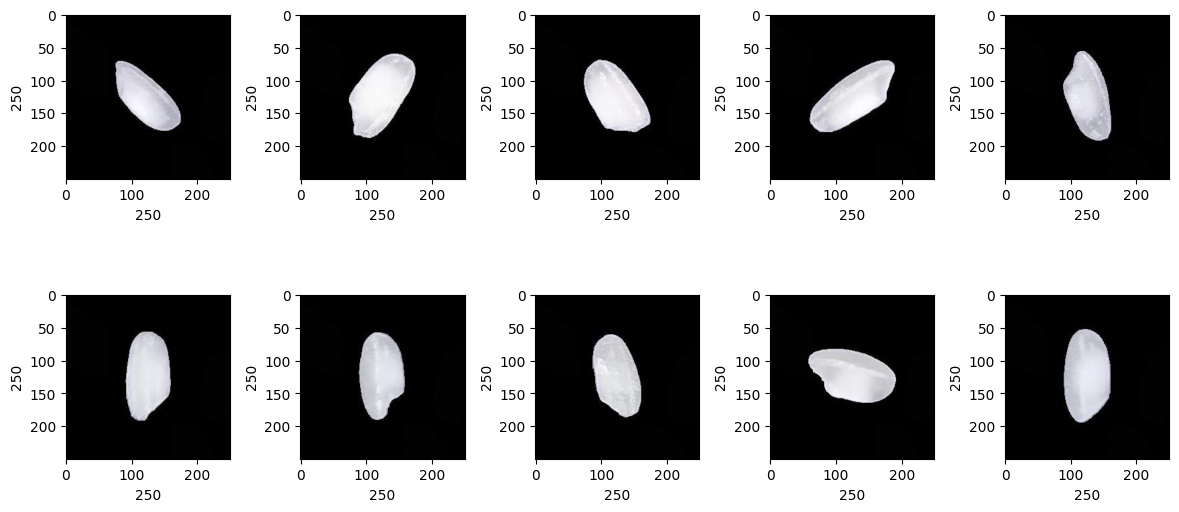

In [15]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Arborio"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 3. Ipsala Rice

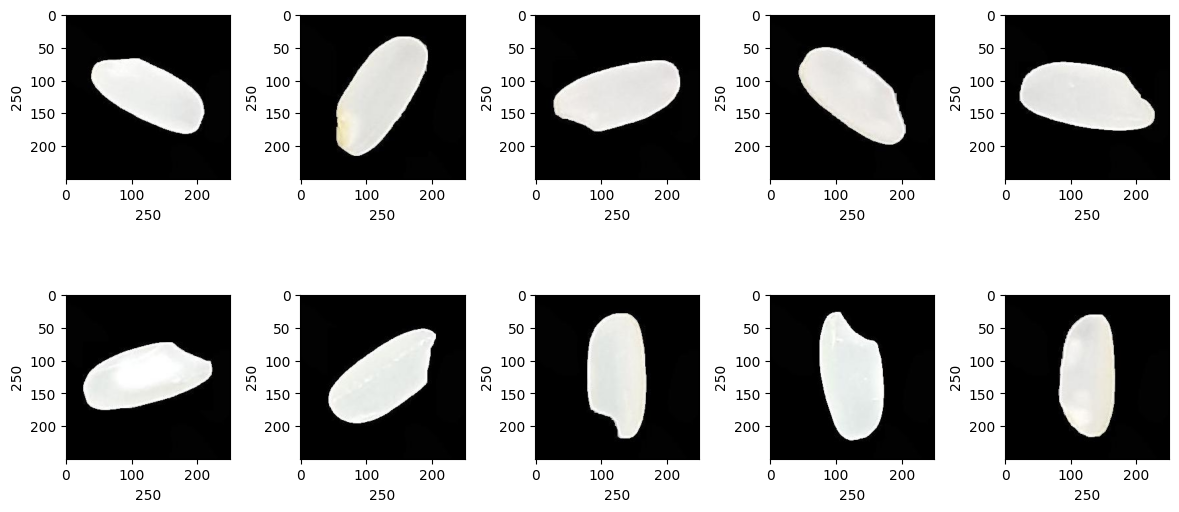

In [16]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Ipsala"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 4. Jasmine Rice

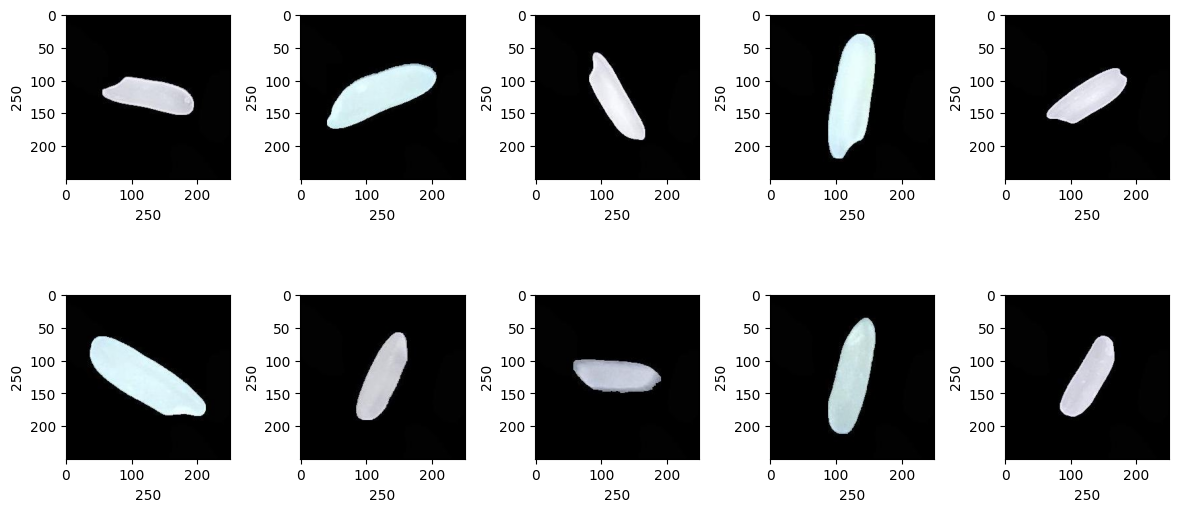

In [17]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Jasmine"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 5. Karacadag Rice

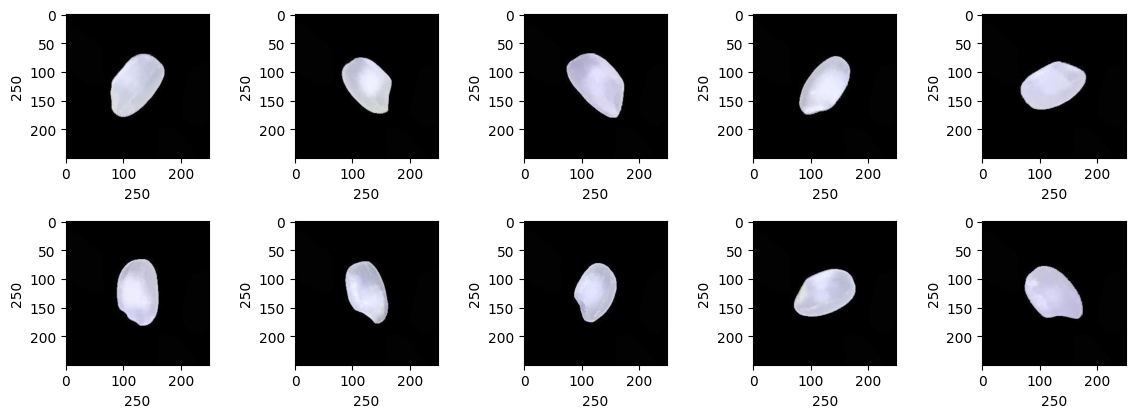

In [18]:
plt.figure(figsize=(12,8))
path = r"C:\Users\vilas\Rice_Image_Dataset\Karacadag"
for i in range(1,11):
    plt.subplot(4,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### Splitting Data into Training, Validation and Testing Sets

## Data Preprocessing

In [19]:
#Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator
train_dir = r"C:\Users\vilas\Rice_Image_Dataset_Splitted\train"

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( train_dir, target_size=(250, 250), batch_size=50)

val_dir = r"C:\Users\vilas\Rice_Image_Dataset_Splitted\val"

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory( val_dir, target_size=(250, 250), batch_size=50)

test_dir = r"C:\Users\vilas\Rice_Image_Dataset_Splitted\test"

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory( test_dir, target_size=(250, 250), batch_size=50)

Found 52500 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


## Building the Convolution Neural Network Model

In [20]:
#Initialising the CNN model
model_adam = Sequential()
# First Convolution Layer
model_adam.add(Conv2D(filters= 16, kernel_size=2, activation='relu', input_shape=[250, 250, 3]))
# First Pooling Layer
model_adam.add(MaxPooling2D(pool_size=2))
# Second Convolution Layer
model_adam.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
# Second Pooling Layer
model_adam.add(MaxPooling2D(pool_size=2))
# Third Convolution Layer
model_adam.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
# Third Pooling Layer
model_adam.add(MaxPooling2D(pool_size=2))

# Flattening
model_adam.add(Flatten())

# Fully Connected Layer
model_adam.add(Dense(128, activation="relu"))
# Deactivating 50% of neuron
#model_adam.add(Dropout(0.5))

# Output Layer
model_adam.add(Dense(5, activation="softmax"))

### Summary of the Model

In [21]:
model_adam.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## Training the CNN Model

### Compiling the CNN Model

In [22]:
model_adam.compile(loss = 'categorical_crossentropy',  optimizer = 'adam', metrics=['accuracy'])


### Model Checkpoint

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
filepath="RICE_TYPE.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### Training the CNN on the Training set and evaluating it on the Test set

In [25]:
from datetime import datetime
start = datetime.now()
# Training the model
history_adam = model_adam.fit( train_generator, steps_per_epoch=250,  epochs=30, validation_data= val_generator, callbacks = callbacks_list) #fit the model using train_generator

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9347
Epoch 1: val_accuracy improved from -inf to 0.98080, saving model to RICE_TYPE.hdf5
250/250 [==============================] - 40s 142ms/step - loss: 0.1885 - accuracy: 0.9347 - val_loss: 0.0637 - val_accuracy: 0.9808
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9785
Epoch 2: val_accuracy improved from 0.98080 to 0.98707, saving model to RICE_TYPE.hdf5
250/250 [==============================] - 32s 127ms/step - loss: 0.0634 - accuracy: 0.9785 - val_loss: 0.0380 - val_accuracy: 0.9871
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9891
Epoch 3: val_accuracy improved from 0.98707 to 0.99233, saving model to RICE_TYPE.hdf5
250/250 [==============================] - 29s 114ms/step - loss: 0.0304 - accuracy: 0.9891 - val_loss: 0.0264 - val_accuracy: 0.9923
Epoch 4/30
250/250 [==============================] 

250/250 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9978
Epoch 29: val_accuracy did not improve from 0.99667
250/250 [==============================] - 28s 111ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0152 - val_accuracy: 0.9953
Epoch 30/30
250/250 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9978
Epoch 30: val_accuracy did not improve from 0.99667
250/250 [==============================] - 27s 110ms/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.0164 - val_accuracy: 0.9949
Training completed in time:  0:14:18.788852


In [43]:
'RICE_TYPE.hdf5'

'RICE_TYPE.hdf5'

In [44]:
score_adam = model_adam.evaluate(test_generator,verbose=0)
accuracy_adam = 100*score_adam[1]
print('Test Loss with Model:', score_adam[0])
print('Test accuracy with Model:', score_adam[1])

Test Loss with Model: 0.018097564578056335
Test accuracy with Model: 0.9955999851226807


In [28]:
history_adam.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

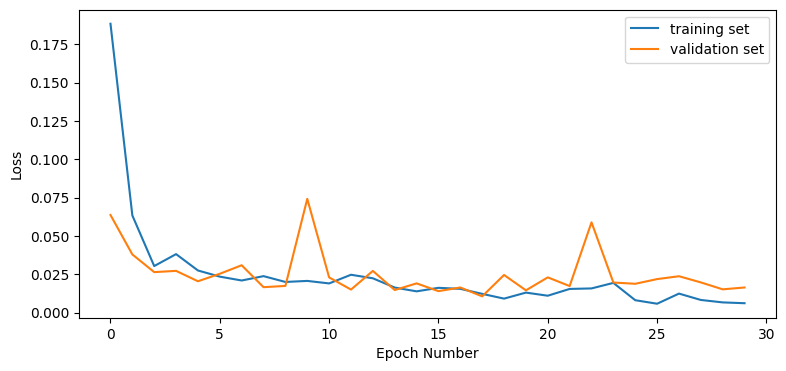

In [29]:
plt.figure(figsize=(9,4))
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history_adam.history['loss'], label = 'training set')
plt.plot(history_adam.history['val_loss'], label = 'validation set')
plt.legend()

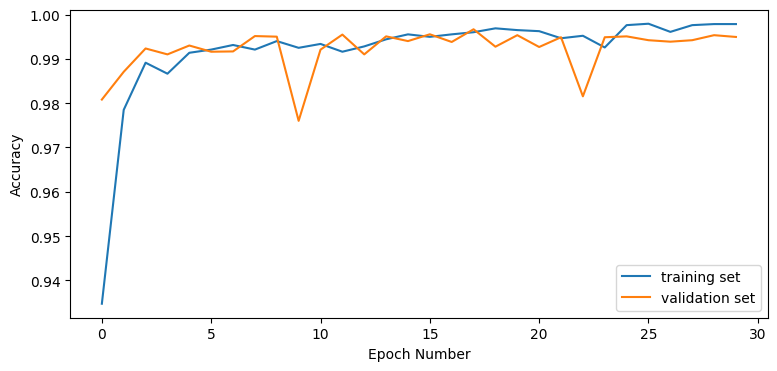

In [30]:
plt.figure(figsize=(9,4))
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history_adam.history['accuracy'], label = 'training set')
plt.plot(history_adam.history['val_accuracy'], label = 'validation set')
plt.legend()

In [31]:
# Load the model
from keras import models
saved_model = models.load_model("RICE_TYPE.hdf5")

In [32]:
score_saved_model = saved_model.evaluate(test_generator,verbose=0)
accuracy_saved_model = 100*score_saved_model[1]
print('Test Loss with saved Model:', score_saved_model[0])
print('Test accuracy with saved Model:',accuracy_saved_model,'%')

Test Loss with saved Model: 0.01365958247333765
Test accuracy with saved Model: 99.58666563034058 %


In [33]:
def predict_image(filename, model):
    img_ = load_img(filename, target_size=(250, 250))
    img_array = img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(class_names[index]).title()), size=18, color='blue')
    plt.imshow(img_array)

In [34]:
class_indices = train_generator.class_indices

In [35]:
class_indices

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

In [36]:
class_names = list(class_indices.keys())

In [37]:
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

1/1 [==============================] - 2s 2s/step


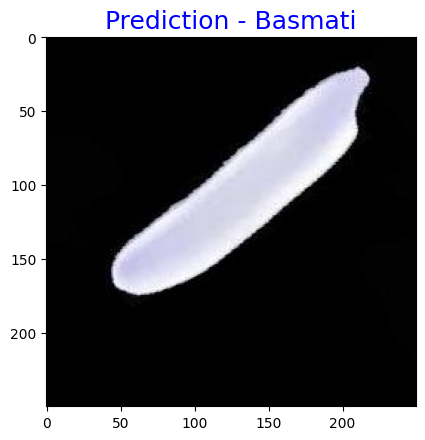

In [38]:
predict_image(r"C:\Users\vilas\Image_Augmentation_Examples\Basmati_Grain_Images_0_521.jpeg", saved_model)

1/1 [==============================] - 0s 14ms/step


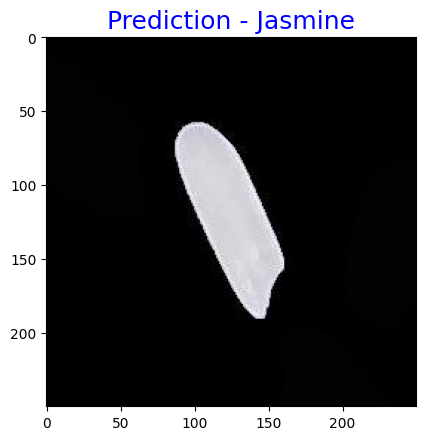

In [39]:
predict_image(r"C:\Users\vilas\Rice_Image_Dataset_Splitted\test\Jasmine\Jasmine (554).jpg", saved_model)

1/1 [==============================] - 0s 15ms/step


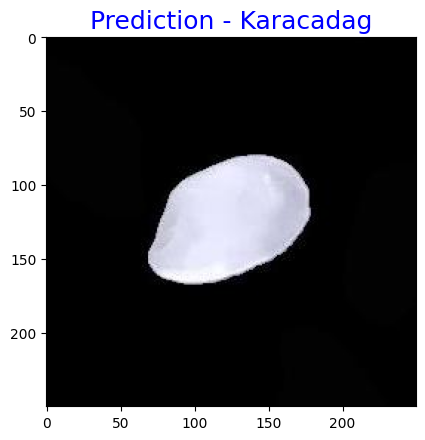

In [40]:
predict_image(r"C:\Users\vilas\Rice_Image_Dataset_Splitted\test\Karacadag\Karacadag (145).jpg", saved_model)

1/1 [==============================] - 0s 14ms/step


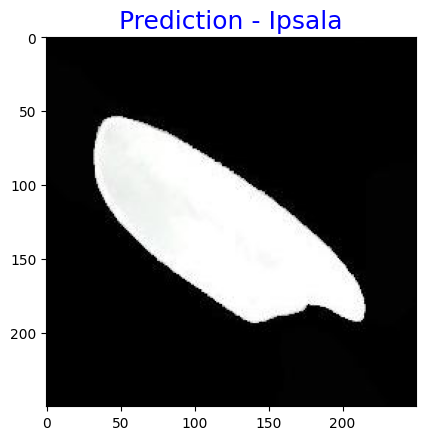

In [41]:
predict_image(r"C:\Users\vilas\Rice_Image_Dataset_Splitted\test\Ipsala\Ipsala (426).jpg", saved_model)

1/1 [==============================] - 0s 13ms/step


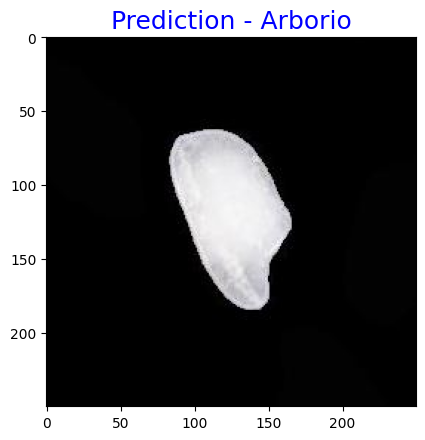

In [42]:
predict_image(r"C:\Users\vilas\Rice_Image_Dataset_Splitted\test\Arborio\Arborio (536).jpg", saved_model)